In [1]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..')))
from utils.models.time_series_transformer import *

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math

import json
import joblib

from bayes_opt import BayesianOptimization
import shap


# Time-Series Transformers

In [2]:
def model_objective(d_model, nhead, num_layers, dropout, learning_rate):
    # Convert float parameters to int
    d_model = int(d_model)
    nhead = int(nhead)
    num_layers = int(num_layers)
    
    # Ensure nhead is even
    nhead = nhead if nhead % 2 == 0 else nhead + 1
    
    # Ensure d_model is even and divisible by nhead
    d_model = ((d_model + 1) // 2) * 2  # Make d_model even
    d_model = (d_model // nhead) * nhead
    
    model = TimeSeriesTransformer(input_dim=X.shape[2], d_model=d_model, nhead=nhead, 
                                  num_layers=num_layers, dropout=dropout, output_dim=prediction_window)
    
    dataset = TensorDataset(X, y)
    train_size = int(0.8 * len(dataset))
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    train_model(model, train_loader, val_loader, scaler_target, epochs=50, lr=learning_rate, patience=10)
    
    _, mae, _, _ = evaluate_model(model, val_loader, scaler_target, nn.HuberLoss())
    
    return -mae


def optimize_hyperparameters():
    pbounds = {
        'd_model': (64, 512),
        'nhead': (2, 16),
        'num_layers': (1, 8),
        'dropout': (0.1, 0.5),
        'learning_rate': (1e-4, 1e-2)
    }

    optimizer = BayesianOptimization(
        f=model_objective,
        pbounds=pbounds,
        random_state=1,
    )

    optimizer.maximize(
        init_points=5,
        n_iter=25,
    )

    return optimizer.max


In [3]:
file_path = r'C:\Users\Administrator\Desktop\DSP391m_cryptocurrency-price-prediction\data\dataset\processed_dataset.csv'
sequence_length = 30
prediction_window = 7
step = 1
batch_size = 64

X, y, scaler_features, scaler_target = prepare_data(file_path, sequence_length, prediction_window, step)

# Optimize hyperparameters and train the best model
best_params = optimize_hyperparameters()
print("Best hyperparameters:", best_params)

# Ensure d_model and nhead are appropriate
d_model = int(best_params['params']['d_model'])
nhead = int(best_params['params']['nhead'])
d_model = ((d_model + 1) // 2) * 2  # Make d_model even
nhead = nhead if nhead % 2 == 0 else nhead + 1
d_model = (d_model // nhead) * nhead

best_model = TimeSeriesTransformer(input_dim=X.shape[2], 
                                   d_model=d_model,
                                   nhead=nhead,
                                   num_layers=int(best_params['params']['num_layers']),
                                   dropout=best_params['params']['dropout'],
                                   output_dim=prediction_window)


dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset, batch_size=batch_size)

train_model(best_model, train_loader, val_loader, scaler_target, 
            epochs=200, lr=best_params['params']['learning_rate'], patience=20)

# Evaluate the model
_, mae, rmse, smape_value = evaluate_model(best_model, val_loader, scaler_target, nn.HuberLoss())
print(f"Final Model - MAE: {mae:.4f}, RMSE: {rmse:.4f}, SMAPE: {smape_value:.2f}%")

|   iter    |  target   |  d_model  |  dropout  | learni... |   nhead   | num_la... |
-------------------------------------------------------------------------------------
Epoch [1/50], Train Loss: 0.4073, Val Loss: 0.3522, Val MAE: 0.7151, Val RMSE: 0.8806, Val SMAPE: 132.80%
Epoch [2/50], Train Loss: 0.3218, Val Loss: 0.2150, Val MAE: 0.5316, Val RMSE: 0.6704, Val SMAPE: 126.76%
Epoch [3/50], Train Loss: 0.2367, Val Loss: 0.1439, Val MAE: 0.4387, Val RMSE: 0.5385, Val SMAPE: 121.86%
Epoch [4/50], Train Loss: 0.2165, Val Loss: 0.1345, Val MAE: 0.4251, Val RMSE: 0.5198, Val SMAPE: 118.57%
Epoch [5/50], Train Loss: 0.1889, Val Loss: 0.0799, Val MAE: 0.3251, Val RMSE: 0.3987, Val SMAPE: 97.29%
Epoch [6/50], Train Loss: 0.1567, Val Loss: 0.0682, Val MAE: 0.2913, Val RMSE: 0.3681, Val SMAPE: 91.75%
Epoch [7/50], Train Loss: 0.1426, Val Loss: 0.0486, Val MAE: 0.2547, Val RMSE: 0.3107, Val SMAPE: 78.78%
Epoch [8/50], Train Loss: 0.1227, Val Loss: 0.0421, Val MAE: 0.2340, Val RMSE: 0.2890, Va

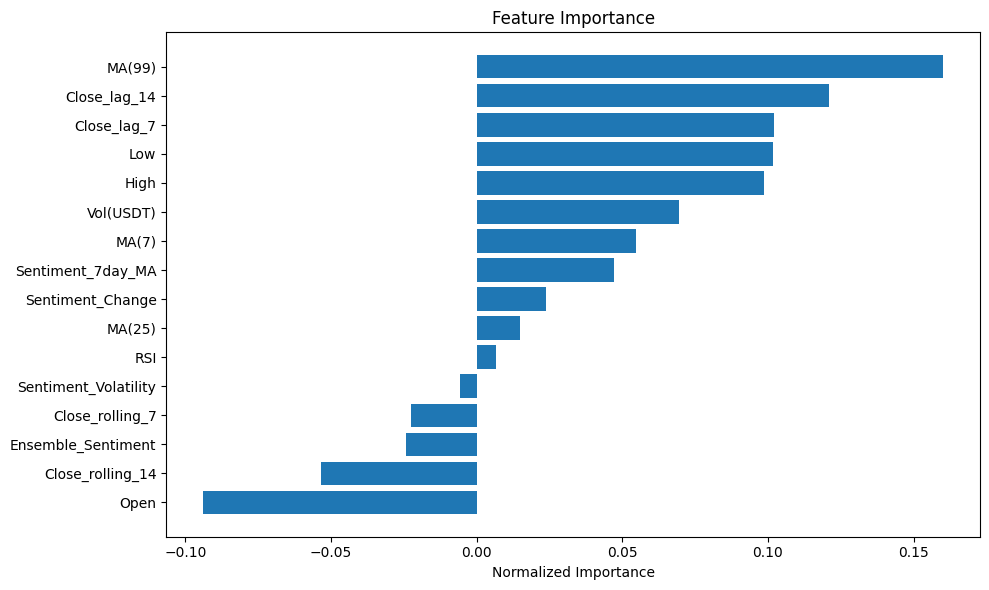

Open: -0.0939
Close_rolling_14: -0.0535
Ensemble_Sentiment: -0.0242
Close_rolling_7: -0.0226
Sentiment_Volatility: -0.0058
RSI: 0.0066
MA(25): 0.0149
Sentiment_Change: 0.0236
Sentiment_7day_MA: 0.0472
MA(7): 0.0547
Vol(USDT): 0.0696
High: 0.0988
Low: 0.1017
Close_lag_7: 0.1019
Close_lag_14: 0.1209
MA(99): 0.1601
Some predictions: [[0.81795543 0.8146064  0.81142396 0.81018656 0.8092912  0.8116218
  0.8141206 ]
 [0.81979936 0.81687284 0.8135631  0.8125992  0.81216884 0.81416976
  0.8180412 ]
 [0.8203413  0.8183392  0.81593317 0.8152982  0.81543887 0.817348
  0.82122004]
 [0.8180528  0.817024   0.81574833 0.8152231  0.81580603 0.8178921
  0.82131654]
 [0.80498576 0.80503404 0.80433446 0.80431765 0.8049242  0.8072448
  0.8105135 ]
 [0.81217927 0.81156325 0.8107412  0.8099718  0.81029785 0.8124312
  0.81523544]
 [0.809506   0.80933595 0.80832505 0.8076197  0.8082373  0.8102116
  0.8128418 ]]
Corresponding actual prices: [[0.82785463 0.77694434 0.80334824 0.786923   0.80547756 0.8017237
  0.

In [4]:
import matplotlib.pyplot as plt

features = ['Open', 'High', 'Low', 'Close_lag_7', 'Close_lag_14',
            'Close_rolling_7', 'Close_rolling_14', 'MA(7)', 'MA(25)', 'MA(99)',
            'RSI', 'Vol(USDT)', 'Ensemble_Sentiment', 'Sentiment_7day_MA',
            'Sentiment_Change', 'Sentiment_Volatility']


def interpret_model(model, X, y, features):
    model.eval()
    
    # Convert tensors to numpy arrays
    X_np = X.numpy()
    y_np = y.numpy()
    
    # Calculate baseline performance
    with torch.no_grad():
        baseline_preds = model(X).numpy()
    baseline_mae = mean_absolute_error(y_np, baseline_preds)
    
    # Calculate feature importance
    feature_importance = []
    for i in range(X.shape[2]):  # Iterate over features
        X_permuted = X_np.copy()
        X_permuted[:, :, i] = np.random.permutation(X_permuted[:, :, i])
        
        with torch.no_grad():
            permuted_preds = model(torch.FloatTensor(X_permuted)).numpy()
        permuted_mae = mean_absolute_error(y_np, permuted_preds)
        
        importance = permuted_mae - baseline_mae
        feature_importance.append(importance)
    
    # Normalize feature importance
    feature_importance = np.array(feature_importance)
    feature_importance = feature_importance / np.sum(np.abs(feature_importance))
    
    # Sort features by importance
    sorted_idx = np.argsort(feature_importance)
    sorted_features = [features[i] for i in sorted_idx]
    sorted_importance = feature_importance[sorted_idx]
    
    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_features)), sorted_importance)
    plt.yticks(range(len(sorted_features)), sorted_features)
    plt.xlabel('Normalized Importance')
    plt.title('Feature Importance')
    plt.tight_layout()
    plt.show()
    
    # Print feature importance
    for feature, importance in zip(sorted_features, sorted_importance):
        print(f"{feature}: {importance:.4f}")


interpret_model(best_model, X, y, features)

# Make predictions
sample_X = X[-7:] 
mask = create_attention_mask(sample_X.size(1)).to(sample_X.device)
with torch.no_grad():
    predictions = best_model(sample_X, mask)

original_predictions = scaler_target.inverse_transform(predictions.numpy())
original_y = scaler_target.inverse_transform(y[-5:].numpy())

print("Some predictions:", original_predictions)
print("Corresponding actual prices:", original_y)

In [5]:
from datetime import datetime

def save_model(model, directory, model_name, val_loader, scaler_target):
    os.makedirs(directory, exist_ok=True)
    _, mae, rmse, smape_value = evaluate_model(model, val_loader, scaler_target, nn.HuberLoss())
    
    metrics = {
        'MAE': float(mae),
        'RMSE': float(rmse),
        'SMAPE': float(smape_value)
    }

    current_date = datetime.now().strftime("%Y%m%d")

    metrics_str = '_'.join([f"{k}_{v:.4f}" for k, v in metrics.items()])
    filename = f"{model_name}_{current_date}_{metrics_str}.pth"

    filepath = os.path.join(directory, filename)

    torch.save(model.state_dict(), filepath)

    model_info = {
        'input_dim': model.embedding.in_features,
        'd_model': model.embedding.out_features,
        'nhead': model.transformer_encoder.layers[0].self_attn.num_heads,
        'num_layers': len(model.transformer_encoder.layers),
        'dropout': float(model.transformer_encoder.layers[0].dropout.p),  # Chuyển đổi sang float
        'output_dim': model.decoder.out_features,
        'metrics': metrics
    }

    info_filepath = filepath.replace('.pth', '_info.json')
    with open(info_filepath, 'w') as f:
        json.dump(model_info, f, indent=4)

    print(f"Model saved to {filepath}")
    print(f"Model info saved to {info_filepath}")
    print(f"Final Model - MAE: {metrics['MAE']:.4f}, RMSE: {metrics['RMSE']:.4f}, SMAPE: {metrics['SMAPE']:.2f}%")
    
    return filename

def save_scalers(scaler_features, scaler_target, directory):
    os.makedirs(directory, exist_ok=True)
    
    joblib.dump(scaler_features, os.path.join(directory, 'scaler_features.joblib'))
    joblib.dump(scaler_target, os.path.join(directory, 'scaler_target.joblib'))
    
    print(f"Scalers saved to {directory}")

def load_scalers(directory):
    scaler_features = joblib.load(os.path.join(directory, 'scaler_features.joblib'))
    scaler_target = joblib.load(os.path.join(directory, 'scaler_target.joblib'))
    
    print(f"Scalers loaded from {directory}")
    return scaler_features, scaler_target

def load_model(directory, filename):
    filepath = os.path.join(directory, filename)
    info_filepath = filepath.replace('.pth', '_info.json')
    
    with open(info_filepath, 'r') as f:
        model_info = json.load(f)
    
    # Khởi tạo mô hình với các siêu tham số đã lưu
    model = TimeSeriesTransformer(
        input_dim=model_info['input_dim'],
        d_model=model_info['d_model'],
        nhead=model_info['nhead'],
        num_layers=model_info['num_layers'],
        dropout=model_info['dropout'],
        output_dim=model_info['output_dim']
    )
    
    model.load_state_dict(torch.load(filepath))
    
    print(f"Model loaded from {filepath}")
    print(f"Model metrics: {model_info['metrics']}")
    return model




In [6]:

saved_filename = save_model(best_model, directory='models', model_name='TimeSeriesTransformer', val_loader=val_loader, scaler_target=scaler_target)
save_scalers(scaler_features, scaler_target, directory='models')

scaler_features, scaler_target = load_scalers(directory='models')
loaded_model = load_model(directory='models', filename=saved_filename)

Model saved to models\TimeSeriesTransformer_20240717_MAE_0.0183_RMSE_0.0260_SMAPE_10.7383.pth
Model info saved to models\TimeSeriesTransformer_20240717_MAE_0.0183_RMSE_0.0260_SMAPE_10.7383_info.json
Final Model - MAE: 0.0183, RMSE: 0.0260, SMAPE: 10.74%
Scalers saved to models
Scalers loaded from models
Model loaded from models\TimeSeriesTransformer_20240717_MAE_0.0183_RMSE_0.0260_SMAPE_10.7383.pth
Model metrics: {'MAE': 0.018323447555303574, 'RMSE': 0.025956351310014725, 'SMAPE': 10.738314688205719}
